# Compare LDA, LSA, etc. ... on bag-of-words approaches

In [1]:
import pandas as pd
import numpy as np
import config
import sys
import re
from ast import literal_eval
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
import wordcloud
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

pd.set_option('display.max_colwidth', 100)

In [2]:
target = config.target_user
target_month = config.target_month

In [3]:
source_dir = "{}/data/twitter/tweets/{}".format(config.dir_prefix, target)

tokenized_and_preprocessed_file = '/'.join([source_dir, target_month  + '_tokenized_and_preprocessed.csv'])
english_file = '/'.join([source_dir, target_month  + '_english.csv'])
french_file = '/'.join([source_dir, target_month  + '_french.csv'])
german_file = '/'.join([source_dir, target_month  + '_german.csv'])

## Tweets in English

In [4]:
tweets_english = pd.read_csv(english_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})

def remove_hash(wordlist):
    return(list(map(lambda x: re.sub(r'^#','',x), wordlist)))

def remove_at(wordlist):
    return(list(map(lambda x: re.sub(r'^@','',x), wordlist)))
    
tweets_english['text_wo_#'] = tweets_english['text_processed'].apply(lambda x: remove_hash(x))
tweets_english['text_wo_#@'] = tweets_english['text_wo_#'].apply(lambda x: remove_at(x))

X_train_en = tweets_english['text_wo_#'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("english"))
#relevant_words = set(['not', 'nor', 'no', 'wasn', 'ain', 'aren', 'very', 'only', 'but', 'don', 'isn', 'weren'])
relevant_words = set()
additional_stopwords = set(['us'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [5]:
X_train_en[-10:-1]

2342    @danielkilian Follow @flippareviews and then go click the link in their bio to see a 100 % Passi...
2343    @MSFTCityNext MSFTCityNext and partners will be discussing smartsolutions to make cities more su...
2344    @PennySchiffer There is no better guide than an outsider who has walked in a strange land some g...
2345    EMEA VP Andrew Sordam gives his thoughts on AI Robotics and integrated cloud in his latest blog ...
2346                                          Time for the first Keynote gartnersym https://t.co/5MmA99rLVa
2347    @MSFTCityNext MSFTCityNext and partners will be discussing smartsolutions to make cities more su...
2348    @ThomasTeskeOrcl EMEA VP Andrew Sordam gives his thoughts on AI Robotics and integrated cloud in...
2349    @MSFTCityNext MSFTCityNext and partners will be discussing smartsolutions to make cities more su...
2350                                            Design Thinking versus Design Doing https://t.co/4Wsp77OgE5
Name: text_wo_#, dtype: obje

# Using CountVectorizer

In [57]:
count_vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = count_vectorizer.fit_transform(X_train_en)
feature_names = count_vectorizer.get_feature_names()
len(feature_names)
words_matrix.shape

(2352, 6807)

## LSA with CountVectorizer

[ 0.0755228   0.10041196  0.10072927  0.09128507]
(4, 6807)


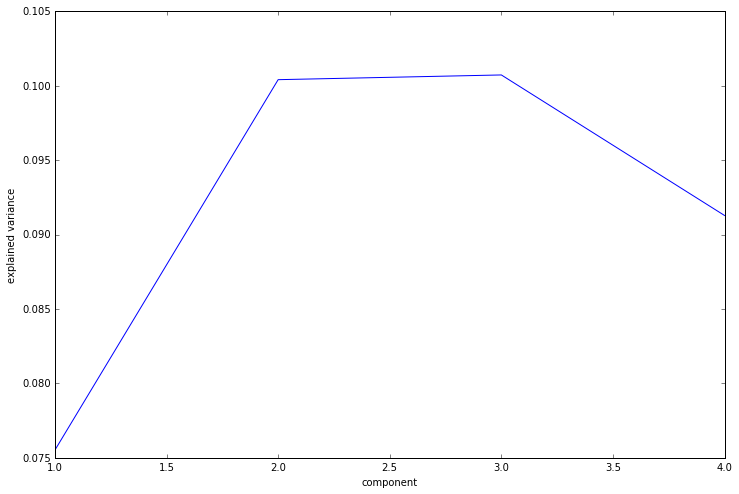

In [75]:
svd = TruncatedSVD(n_components=4, n_iter=10)
#svd = TruncatedSVD(n_components=10, algorithm = 'arpack')
X = svd.fit_transform(words_matrix)
print(svd.explained_variance_)

print(svd.components_.shape)

plt.figure(figsize = (12, 8))
plt.xlabel('component')
plt.ylabel('explained variance')
plt.plot(np.arange(1,svd.n_components+1), svd.explained_variance_)
plt.show()


In [76]:
for comp_idx, component in enumerate(svd.components_):
        print("Component #%d:" % comp_idx)
        top_n = ['{}: {}'.format(round(component[i],1), feature_names[i]) for i in component.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))


Component #0:
0.5: oracle
0.4: @sfonplsql
0.3: sql
0.2: pl
0.1: new
0.1: database
0.1: plsql
0.1: @lukaseder
0.1: data
0.1: bigdata
0.1: code
0.1: need
0.1: cloud
0.1: make
0.1: find
0.1: 12c
0.1: @talend
0.1: use
0.1: learn
0.1: full
Component #1:
0.3: 🇧
0.3: 🇬
0.3: ️
0.3: @sfonplsql
0.3: ❤
0.3: 😍
0.2: sql
0.1: 😁
0.1: 👏
0.1: pl
0.1: plsql
0.1: 😳
0.1: 💙
0.1: make
0.1: much
0.1: 101
0.1: thx
0.1: @pjcjohnson
0.1: follow
0.1: @oracledatabase
Component #2:
0.4: oracle
0.3: 🇧
0.3: 🇬
0.3: ️
0.3: ❤
0.3: 😍
0.1: 😁
0.1: 👏
0.1: need
0.1: 12c
0.1: 😳
0.1: 💙
0.1: find
0.1: import
0.1: full
0.1: database
0.1: example
0.1: files
0.1: transportable
0.1: par
Component #3:
0.3: bigdata
0.3: data
0.2: @talend
0.2: partners
0.2: business
0.2: @msftcitynext
0.2: make
0.2: scewc16
0.2: iamcp
0.1: webinar
0.1: msftcitynext
0.1: join
0.1: got
0.1: learn
0.1: cities
0.1: discussing
0.1: sustainable
0.1: smartsolutions
0.1: 2016
0.1: drive


## PCA with CountVectorizer

In [79]:
# compare with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(words_matrix.toarray())
print(pca.explained_variance_ratio_) 

[ 0.00979319  0.00928147]


In [80]:
for comp_idx, component in enumerate(pca.components_):
        print("Component #%d:" % comp_idx)
        top_n = ['{}: {}'.format(round(component[i],1), feature_names[i]) for i in component.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))


Component #0:
0.6: oracle
0.3: sql
0.2: @sfonplsql
0.1: pl
0.1: database
0.1: need
0.1: 12c
0.1: find
0.1: plsql
0.1: import
0.1: full
0.1: example
0.1: files
0.1: export
0.1: par
0.1: transportable
0.1: https://t.co/ve9xmypvy4
0.1: @mikedietrichde
0.1: expd
0.1: code
Component #1:
0.4: 🇬
0.4: 🇧
0.4: ️
0.4: ❤
0.4: 😍
0.2: 😁
0.2: 👏
0.1: 😳
0.1: 💙
0.1: much
0.1: thx
0.1: @pjcjohnson
0.1: follow
0.1: sql
0.1: @sfonplsql
0.0: pl
0.0: plsql
0.0: oracle
0.0: code
0.0: 101


## Gaussian mixture with CountVectorizer

In [91]:
from sklearn import mixture
em = mixture.GaussianMixture(n_components=2, covariance_type='full')
#em = mixture.BayesianGaussianMixture(n_components=5)
em.fit(words_matrix.toarray())

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [93]:
print('Iterations: {}, converged: {}'.format(em.n_iter_, em.converged_))
print('Component weights: {}'.format(em.weights_))
print('Component means: {}'.format(em.means_))
print('Predicted component: {}'.format(em.predict(words_matrix[:5].toarray())))
print('Probability per component: {}'.format(em.predict_proba(words_matrix[:5].toarray())))
print('weighted log prob of samples: {}'.format(em.score_samples(words_matrix[:5].toarray())))

Iterations: 1, converged: True
Component weights: [  4.25170068e-04   9.99574830e-01]
Component means: [[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.00552956  0.01148447  0.0008507  ...,  0.0017014   0.00255211
   0.00042535]]
Predicted component: [1 1 1 1 1]
Probability per component: [[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]
weighted log prob of samples: [ 33897.08167674  33897.08167674  33374.82864216  32788.17774475
  32787.14402984]


# Using tf-idf vectorizer

## LSA with tf-idf vectorizer

In [94]:
tfidf_vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = str.split, max_df=0.5, min_df=5,
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = tfidf_vectorizer.fit_transform(X_train_en)
feature_names = tfidf_vectorizer.get_feature_names()
len(feature_names), tfidf_vectorizer.idf_.shape

(1278, (1278,))

[ 0.00479117  0.00816371  0.00825172  0.00750802]
(4, 1278)


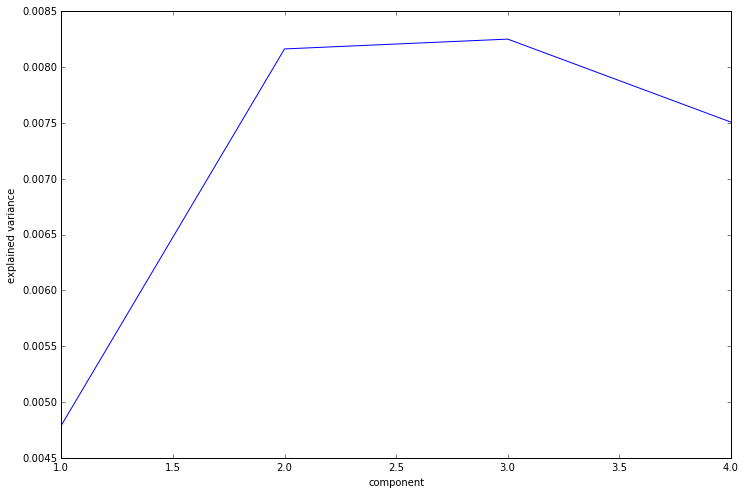

In [95]:
svd = TruncatedSVD(n_components=4, n_iter=10)
#svd = TruncatedSVD(n_components=10, algorithm = 'arpack')
X = svd.fit_transform(words_matrix)
print(svd.explained_variance_)

print(svd.components_.shape)

plt.figure(figsize = (12, 8))
plt.xlabel('component')
plt.ylabel('explained variance')
plt.plot(np.arange(1,svd.n_components+1), svd.explained_variance_)
plt.show()


In [97]:
for comp_idx, component in enumerate(svd.components_):
        print("Component #%d:" % comp_idx)
        top_n = ['{}: {}'.format(round(component[i],1), feature_names[i]) for i in component.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))


Component #0:
0.3: oracle
0.2: make
0.2: @lukaseder
0.2: @sfonplsql
0.2: partners
0.2: scewc16
0.2: @msftcitynext
0.2: msftcitynext
0.2: discussing
0.2: cities
0.2: sustainable
0.2: smartsolutions
0.1: sql
0.1: data
0.1: cloud
0.1: bigdata
0.1: thanks
0.1: use
0.1: learn
0.1: database
Component #1:
0.3: msftcitynext
0.3: scewc16
0.3: partners
0.3: @msftcitynext
0.3: discussing
0.3: smartsolutions
0.3: sustainable
0.3: cities
0.2: make
0.0: transportation
0.0: public
0.0: meeting
0.0: msft
0.0: connect
0.0: @tonitwhitley
0.0: cvp
0.0: wwps
0.0: plenary
0.0: picking
0.0: @microsoft
Component #2:
0.3: still
0.3: apple
0.3: use
0.3: iphone
0.3: appears
0.3: considering
0.3: foldable
0.3: @alphahelixsmc
0.3: https://t.co/kydfrkzjm0
0.3: would
0.0: 10
0.0: msftcitynext
0.0: @msftcitynext
0.0: scewc16
0.0: smartsolutions
0.0: sustainable
0.0: cities
0.0: discussing
0.0: really
0.0: insider
Component #3:
0.7: @lukaseder
0.1: @sfonplsql
0.1: really
0.1: pool
0.1: :)
0.1: @rotnroll666
0.1: @vlad

## PCA with tf-idf vectorizer

In [99]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(words_matrix.toarray())
print(pca.explained_variance_ratio_) 

[ 0.00980909  0.00850986]


In [100]:
for comp_idx, component in enumerate(pca.components_):
        print("Component #%d:" % comp_idx)
        top_n = ['{}: {}'.format(round(component[i],1), feature_names[i]) for i in component.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))


Component #0:
0.3: partners
0.3: scewc16
0.3: msftcitynext
0.3: @msftcitynext
0.3: make
0.3: discussing
0.3: smartsolutions
0.3: sustainable
0.3: cities
0.0: learn
0.0: transportation
0.0: meeting
0.0: public
0.0: connect
0.0: msft
0.0: https
0.0: today
0.0: technology
0.0: plenary
0.0: picking
Component #1:
0.3: still
0.3: apple
0.3: use
0.3: would
0.3: iphone
0.3: appears
0.3: https://t.co/kydfrkzjm0
0.3: @alphahelixsmc
0.3: considering
0.3: foldable
0.1: @lukaseder
0.0: 10
0.0: one
0.0: really
0.0: msftcitynext
0.0: @msftcitynext
0.0: scewc16
0.0: smartsolutions
0.0: sustainable
0.0: cities


## Gaussian mixture with tf-idf vectorizer

In [101]:
from sklearn import mixture
em = mixture.GaussianMixture(n_components=2, covariance_type='full')
#em = mixture.BayesianGaussianMixture(n_components=5)
em.fit(words_matrix.toarray())

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [102]:
print('Iterations: {}, converged: {}'.format(em.n_iter_, em.converged_))
print('Component weights: {}'.format(em.weights_))
print('Component means: {}'.format(em.means_))
print('Predicted component: {}'.format(em.predict(words_matrix[:5].toarray())))
print('Probability per component: {}'.format(em.predict_proba(words_matrix[:5].toarray())))
print('weighted log prob of samples: {}'.format(em.score_samples(words_matrix[:5].toarray())))

Iterations: 2, converged: True
Component weights: [ 0.90263605  0.09736395]
Component means: [[ 0.00257616  0.00423334  0.00103775 ...,  0.00146196  0.0028224
   0.00082154]
 [ 0.          0.00198471  0.         ...,  0.          0.          0.        ]]
Predicted component: [0 0 0 0 0]
Probability per component: [[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
weighted log prob of samples: [ 4415.75777644  4415.75777644  3951.41380257  3729.54534536  3523.39354361]


# LDA

## LDA with CountVectorizer

In [13]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

/home/key/python/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/key/python/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/key/python/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/key/python/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value

In [14]:
def generate_word_cloud(model, topic_number, max_words, width, height):
    topic = model.components_[topic_number]
    frequencies = [(feature_names[i], topic[i]) for i in topic.argsort()]
    top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
    cloud = wordcloud.WordCloud(width=width, height=height, max_words=max_words, random_state=0).generate_from_frequencies(frequencies)
    return cloud
  
def show_word_clouds(model, subplots, num_words):    
    for i in range(model.n_topics):
        wordcloud = generate_word_cloud(model = model, topic_number = i, max_words = num_words,width = 800, height = 600)
        subplots[i].imshow(wordcloud)
        subplots[i].axis('off')

def print_top_words(model, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))
        print()
    


## Most dominating topics - overall

Topic #0:
42.7: oracle
38.4: @lukaseder
35.8: @sfonplsql
28.0: make
27.7: cloud
27.6: new
26.5: data
26.3: thanks
25.9: bigdata
25.3: great



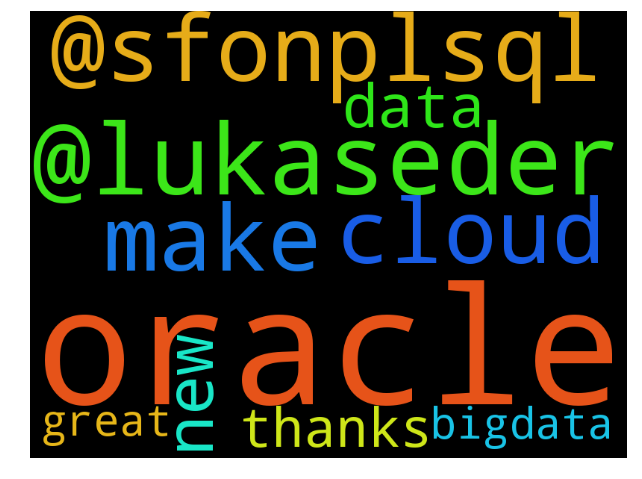

In [15]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)


## Most dominating topics - 2 clusters

Topic #0:
29.8: @lukaseder
23.1: make
22.8: @msftcitynext
22.3: one
22.1: partners
21.2: scewc16
20.3: msftcitynext
20.0: it's
19.2: discussing
19.2: oracle
19.0: cities
18.8: smartsolutions
18.8: sustainable
16.9: see
16.9: use
16.5: need
16.1: good
15.2: 1
15.1: like
14.6: know

Topic #1:
27.2: cloud
25.5: thanks
25.1: bigdata
24.8: data
24.5: great
23.5: oracle
22.4: @sfonplsql
19.7: 2016
19.4: sql
16.4: video
16.4: iot
16.3: business
16.3: @franckpachot
16.2: @talend
15.9: @oracle
15.3: @ukoug
14.6: iamcp
14.2: check
13.8: new
13.2: service



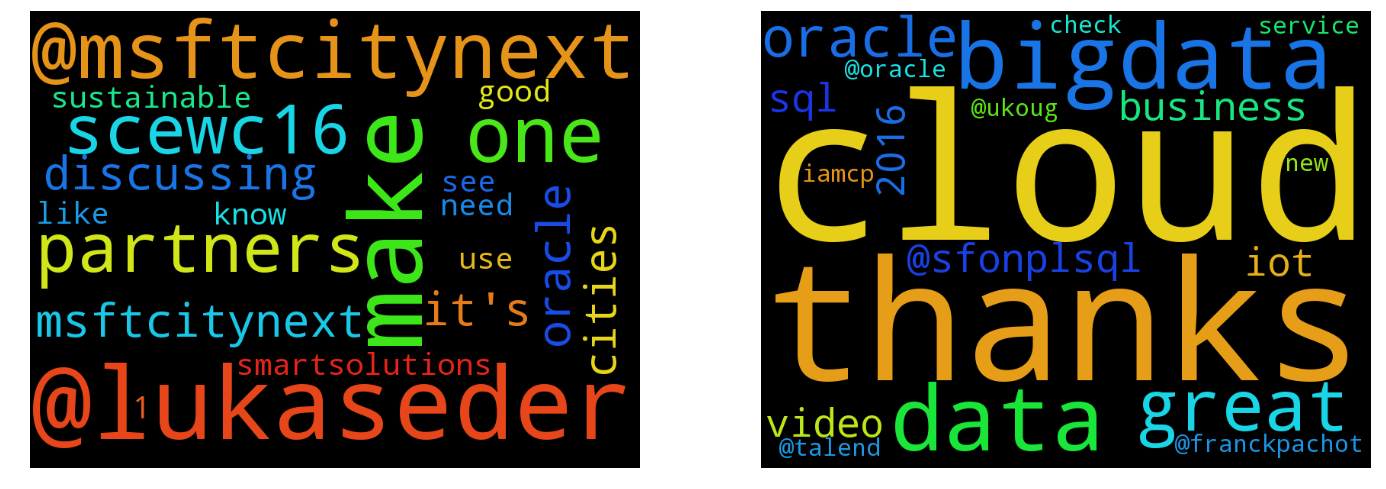

In [16]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters

Topic #0:
21.1: one
18.2: good
17.9: oracle
16.9: see
15.1: 1
14.9: like
14.6: use
13.4: @lukaseder
12.8: still
12.7: really
12.6: first
12.5: would
11.2: i'm
11.1: :-)
11.0: need
10.7: future
10.5: orclapex
10.4: could
10.2: @sfonplsql
10.1: find

Topic #1:
24.6: @lukaseder
21.4: data
20.7: :)
20.6: thanks
19.6: oracle
19.6: bigdata
16.7: @ukoug
16.6: @franckpachot
14.8: looking
14.0: it's
13.9: get
13.4: want
13.1: time
13.1: service
13.0: join
12.3: 2016
11.9: learn
11.6: check
11.5: iamcp
11.5: latest

Topic #2:
23.6: partners
22.6: @msftcitynext
21.7: sql
21.1: scewc16
20.2: make
20.2: msftcitynext
19.1: discussing
18.9: cities
18.7: smartsolutions
18.7: sustainable
17.9: cloud
16.3: video
15.1: @sfonplsql
14.8: @oracle
12.9: microsoft
11.7: great
10.9: go
10.5: live
10.4: plsql
10.0: https



(0.0, 1.0, 0.0, 1.0)

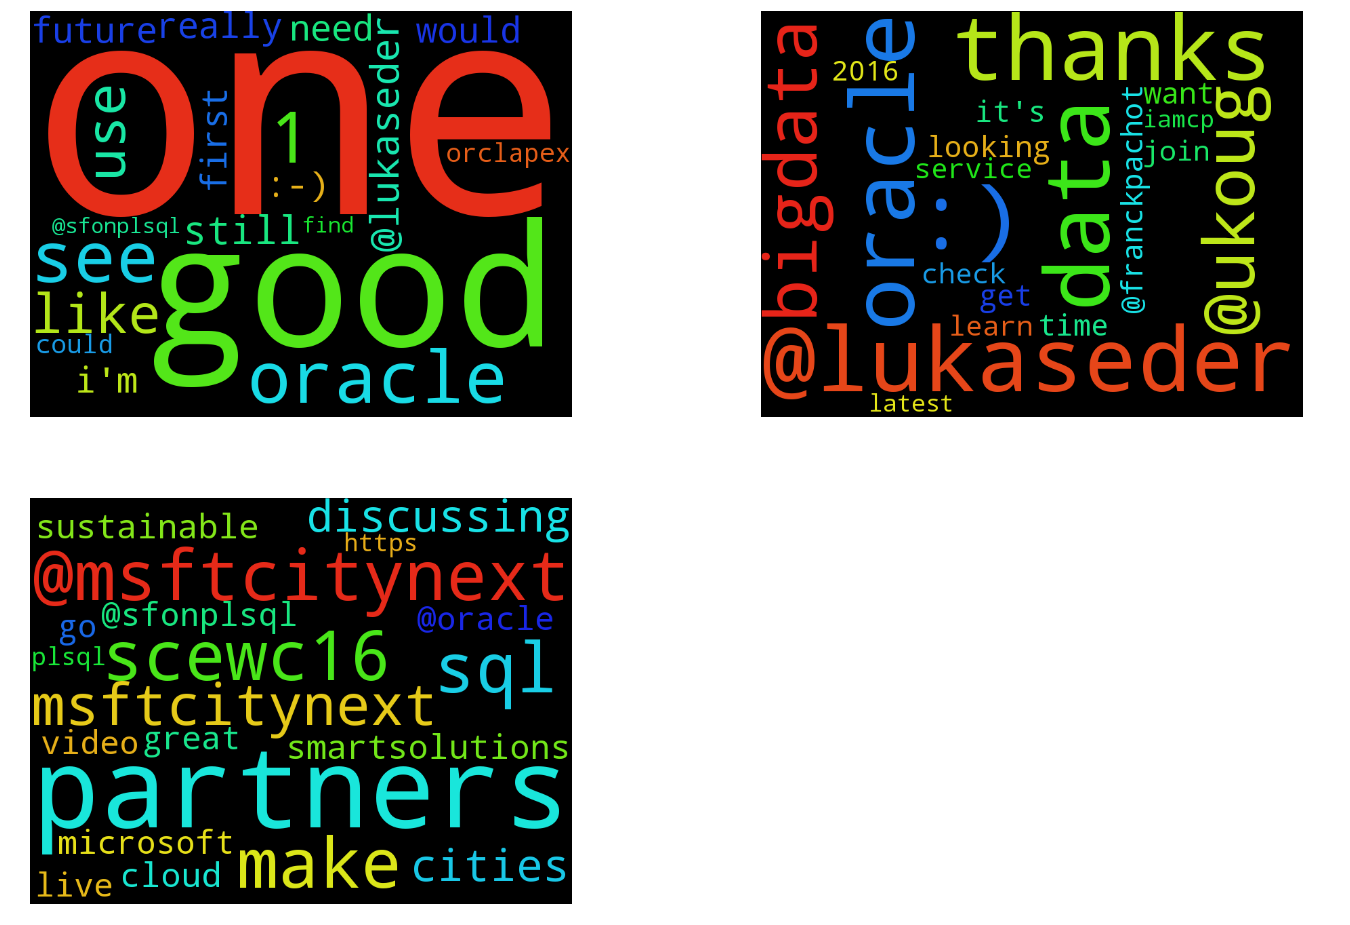

In [17]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters

Topic #0:
23.0: one
16.8: see
14.8: like
13.3: first
12.7: still
12.1: good
12.0: use
11.1: i'm
10.9: go
10.6: future
10.6: would
10.4: orclapex
10.4: it's
10.2: could
9.2: year
9.1: back
9.0: need
8.9: 😊
8.6: apple
8.3: oracle

Topic #1:
22.5: @msftcitynext
21.0: scewc16
20.2: make
20.1: msftcitynext
20.1: partners
19.0: discussing
18.8: cities
18.6: sustainable
18.6: smartsolutions
18.2: thanks
16.1: iot
14.3: iamcp
13.4: data
13.2: service
12.9: join
12.7: 1
12.5: get
11.7: cloud
11.5: blog
11.1: @franckpachot

Topic #2:
19.4: 2016
16.5: sql
16.2: video
15.9: @oracle
15.8: great
15.6: bigdata
15.6: cloud
12.8: microsoft
12.5: data
11.6: @pennyschiffer
11.3: plsql
11.2: using
11.0: @sfonplsql
10.8: @talend
10.6: today
10.2: oracle
10.1: aws
9.9: pl
9.6: @oraclepartners
9.0: november

Topic #3:
23.9: @lukaseder
20.7: :)
13.8: oracle
13.4: @sfonplsql
12.0: @goldrauschents
12.0: really
10.2: right
10.1: @ukoug
9.7: want
9.5: @oracledatabase
8.5: work
8.4: new
8.1: know
8.0: 12.2
7.8: @r

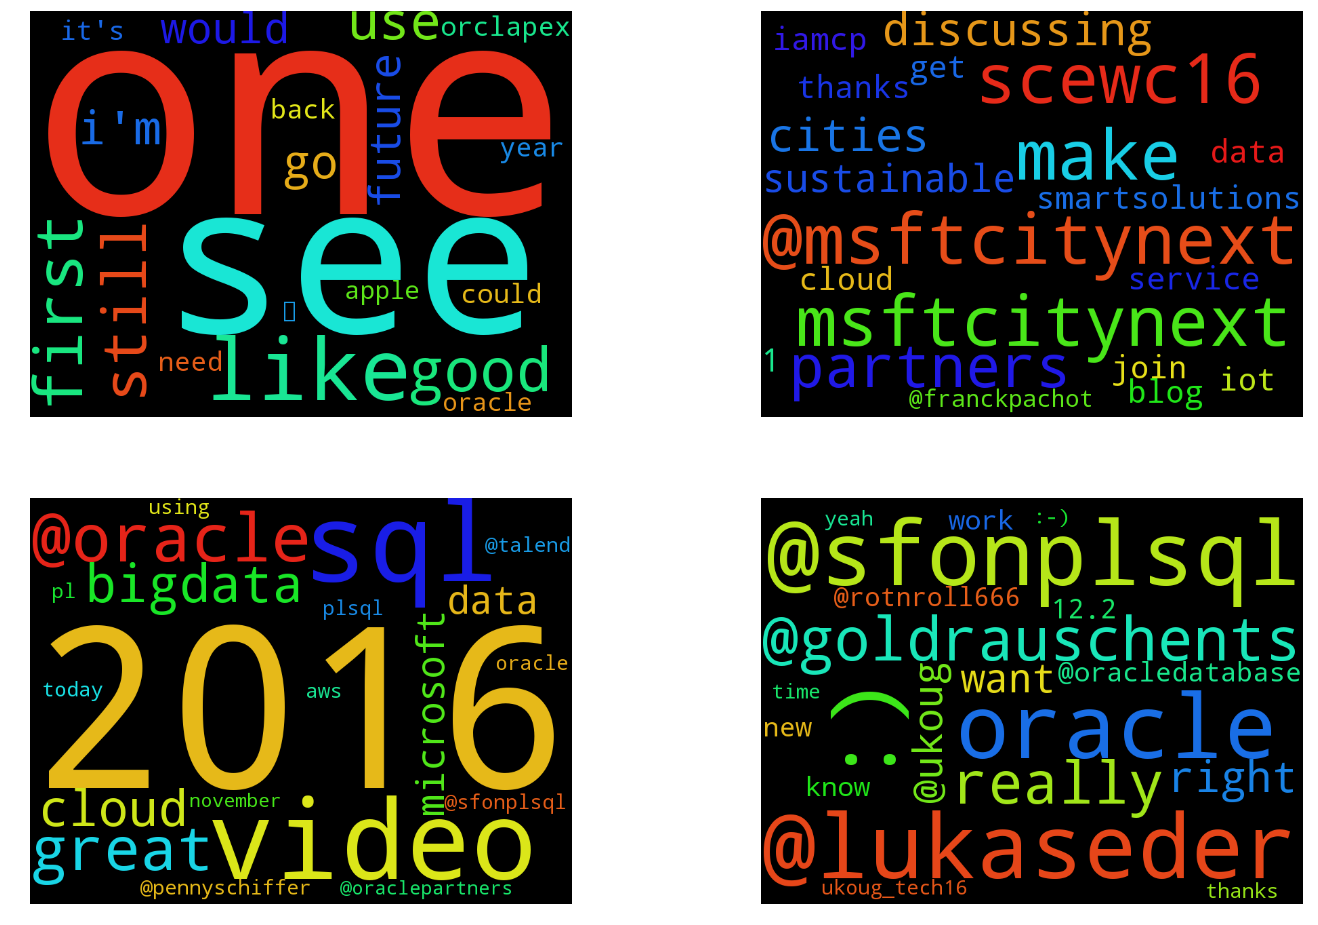

In [18]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

In [19]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_en)

co_occurrence_matrix = words_matrix.T * words_matrix
co_occurrence_matrix.setdiag(0) 
array = co_occurrence_matrix.toarray()
co_occurrences = pd.DataFrame(array)
co_occurrences.shape

(6807, 6807)

In [20]:
vocab = vectorizer.get_feature_names()
co_occurrences['word'] = vocab
co_occurrences = co_occurrences.set_index('word')
co_occurrences.head()

,0,1,2,3,4,5,6,7,8,9,...,6797,6798,6799,6800,6801,6802,6803,6804,6805,6806
word,,,,,,,,,,,,,,,,,,,,,
$,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
):,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
);,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
-->,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
co_occurrences.columns = vocab
co_occurrences.head()

,$,%,):,);,-->,.,..,/8,0,0.0017,...,😊,😍,😎,😜,😩,😭,😮,😳,🚀,🤖
word,,,,,,,,,,,,,,,,,,,,,
$,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
):,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
);,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
-->,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Co-occurrences for: oracle
database                   38
sql                        19
12c                        18
service                    17
need                       16
import                     15
find                       15
@ukoug                     15
full                       14
cloud                      14
export                     13
https://t.co/ve9xmypvy4    13
Name: oracle, dtype: int64




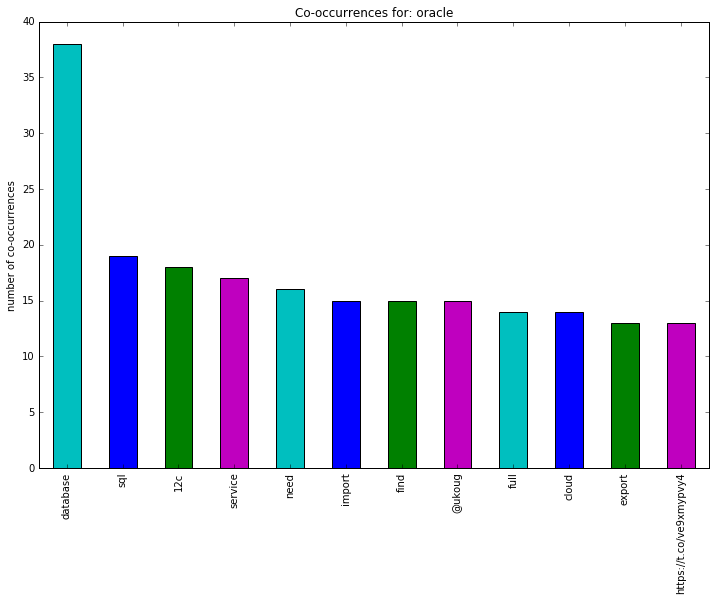

Co-occurrences for: microsoft
iamcp        18
teams        18
office        9
available     8
2015          6
oldy          6
goody         6
cassandra     6
aprils        6
fools         6
mongodb       6
voltdb        6
Name: microsoft, dtype: int64




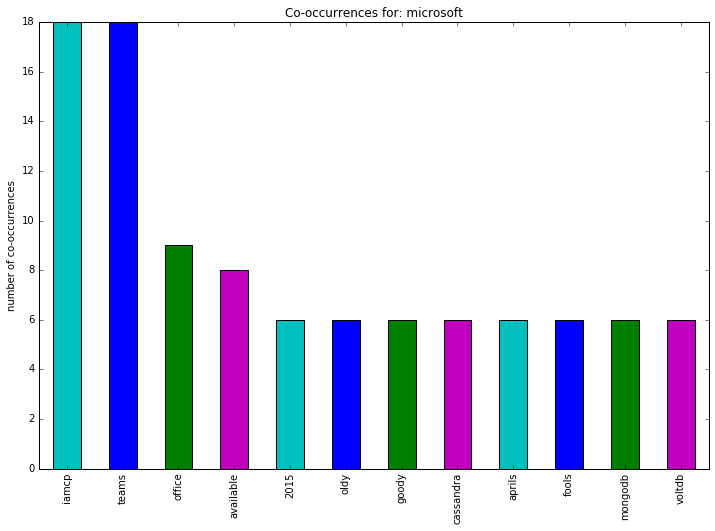

Co-occurrences for: talend
@talend                     14
bigdata                      8
data                         8
dataprep                     7
101                          5
https://t.co/hfoyhkxp56…     5
1.3                          5
intro                        5
datascience                  5
https://t.co/dhnv6e6i06      5
columns                      5
cleaning                     5
Name: talend, dtype: int64




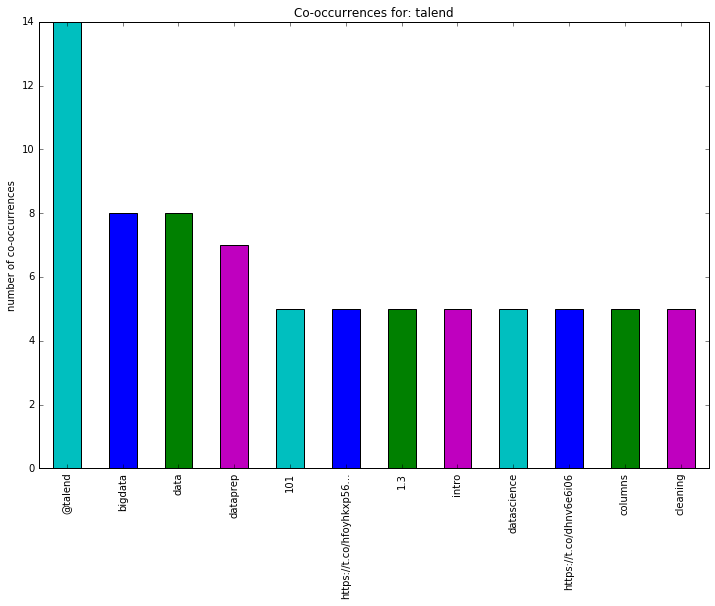

Co-occurrences for: bigdata
@talend        36
data           30
datascience    21
aws            11
analytics      10
winner         10
partners        9
@northbays      9
benefits        9
building        9
@47lining       9
@cloudwick      9
Name: bigdata, dtype: int64




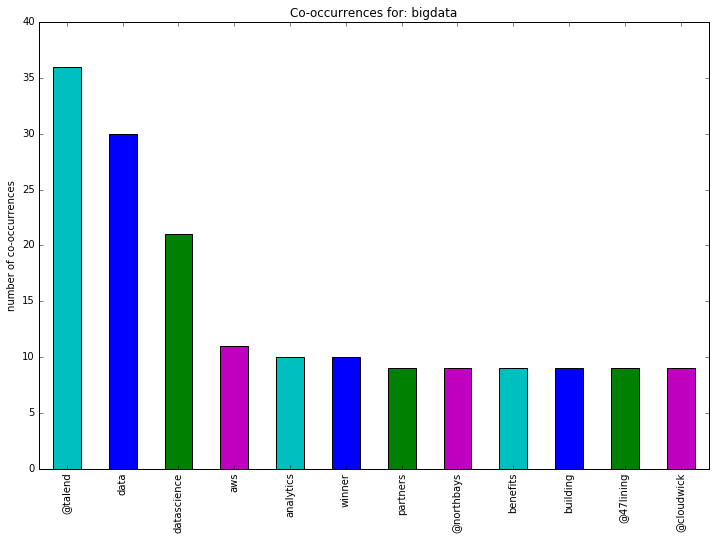

Co-occurrences for: cloud
@oracle            30
@oraclepartners    15
oracle             14
paas               14
get                14
iaas               12
streaming          10
service             9
@ukoug              8
partner             8
iot                 8
processes           7
Name: cloud, dtype: int64




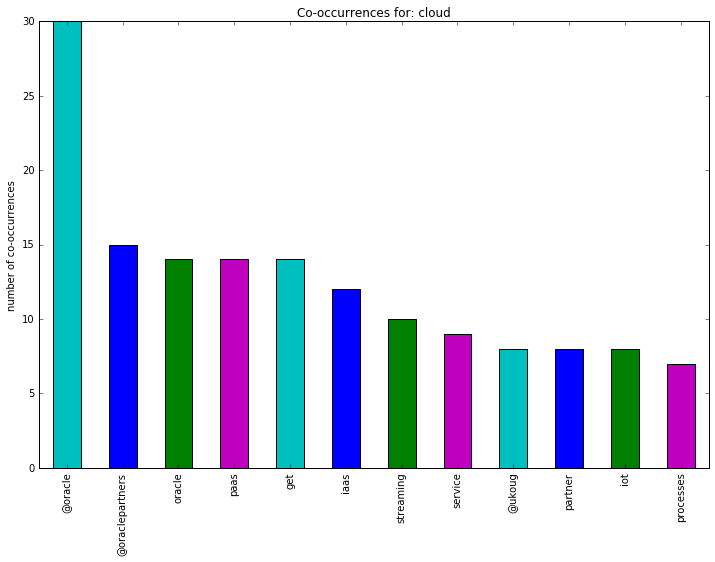

In [22]:
def get_co_occurrences(df, word, n):
    coocs = df.loc[word]
    sorted = coocs.sort_values(ascending = False)
    return sorted[:n]

def plot_co_occurrences(word, coocs):
    plt.figure(figsize = (12, 8))
    plt.ylabel('number of co-occurrences')
    plt.title('Co-occurrences for: {}'.format(word))
    coocs.plot(kind='bar', color = colors)
    plt.show()
    
words = ['oracle', 'microsoft', 'talend', 'bigdata', 'cloud']    
n = 12
colors = 'cbgm'

for w in words: 
    coocs = get_co_occurrences(co_occurrences, w, n)
    print('Co-occurrences for: {}\n{}\n\n'.format(w, coocs))
    plot_co_occurrences(w, coocs)
